In [1]:
import numpy as np
import cv2

In [839]:
test_lst = [1,2,3]
asdf = list(map(lambda x: x+1, test_lst))
print(asdf)
print(test_lst)

[2, 3, 4]
[1, 2, 3]


In [838]:
import torch
mx = torch.randn(3,3)
vec = torch.randn(3,1)
res = torch.matmul(mx, vec)
res.size()
vec2 = vec.view(3)
res2 = torch.matmul(mx,vec2)
print(res)
print(res2)

tensor([[ 4.2816],
        [-1.4986],
        [-0.9198]])
tensor([ 4.2816, -1.4986, -0.9198])


In [761]:
class Camera:
    def __init__(self, name, image_shape, K, D, Transform, fisheye, px_cutoff, base_img):
        self.name = name
        self.image_shape = image_shape
        self.K_mx = K
        self.D_mx = D
        self.Transform_mx = Transform
        self.R = Transform[0:3,0:3]
        self.T_vec = Transform[0:3,3:4]
        self.R_vec = cv2.Rodrigues(self.R)[0]
        self.cam_pos = np.matmul((-1 * np.transpose(self.R)), self.T_vec)
        self.fisheye = fisheye
        self.px_cutoff = px_cutoff
        self.base_img = base_img

    def project(self, points):
        if not isinstance(points, np.ndarray):
            if isinstance(points, list):
                points = np.array(points)
            else:
                points = np.array([[list(points)]])
        elif points.ndim == 1:
                points = np.asarray([[points]])
        if self.fisheye:
            return cv2.fisheye.projectPoints(objectPoints=points,rvec=self.R_vec.reshape(3),tvec=self.T_vec.reshape(3),K=self.K_mx.reshape(3,3),D=self.D_mx.reshape(4))[0]
        else:
            return cv2.projectPoints(points,self.R_vec,self.T_vec,self.K_mx,self.D_mx)[0]


In [303]:
for cam in cams:
    print(cam.name)
    print(cam.cam_pos)

17391290
[[-1.69874353]
 [-7.52545936]
 [30.14072514]]
17391304
[[-0.28937107]
 [ 0.14965498]
 [-0.03087656]]
19412282
[[ 4.0928255 ]
 [ 0.73987695]
 [31.05392739]]
21340171
[[-5.99229746]
 [ 1.69738957]
 [30.64539092]]


In [294]:
d02 = np.linalg.norm(cams[0].cam_pos - cams[2].cam_pos)
d03 = np.linalg.norm(cams[0].cam_pos - cams[3].cam_pos)
d23 = np.linalg.norm(cams[2].cam_pos - cams[3].cam_pos)
print(d02)
print(d03)
print(d23)

10.133705866863139
10.185785934405292
10.138709858701857


In [280]:
# get center of triangle
side1 = cams[0].cam_pos - cams[2].cam_pos
side2 = cams[3].cam_pos - cams[2].cam_pos
halfway_side1 = side1 / 2
halfway_side2 = side2 / 2
#med1 = cams[3].cam_pos - halfway_side1
#med2 = cams[0].cam_pos - halfway_side2


In [145]:
!pip3 install shapely

  Cache entry deserialization failed, entry ignored
    100% |████████████████████████████████| 1.2MB 10.4MB/s ta 0:00:01
You are using pip version 10.0.1, however version 21.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [148]:
import shapely
from shapely.geometry import LineString, Point

In [174]:
halfway_point1 = halfway_side1 - (-1* cams[2].cam_pos)
halfway_point2 = halfway_side2 - (-1* cams[2].cam_pos)

In [175]:
line1 = LineString([tuple(halfway_point1.reshape(3).tolist()[:2]),tuple(cams[3].cam_pos.reshape(3).tolist()[:2])])
line2 = LineString([tuple(halfway_point2.reshape(3).tolist()[:2]),tuple(cams[0].cam_pos.reshape(3).tolist()[:2])])
intsec = line1.intersection(line2)
center_x, center_y = intsec.x, intsec.y
print(center_x, center_y)

-1.199405162390885 -1.6960642799627483


In [176]:
print(cams[1].R)
print(cams[1].T_vec)
print(cams[1].cam_pos)

[[ 0.99995692  0.00179442 -0.00910709]
 [-0.00175208  0.99998763  0.00465528]
 [ 0.00911533 -0.00463912  0.99994769]]
[[ 0.28880887]
 [-0.15001639]
 [ 0.03420693]]
[[-0.28937107]
 [ 0.14965498]
 [-0.03087656]]


In [177]:
test_point = np.array([[center_x,center_y,39.0]], dtype=np.float32)
test_point2 = np.array([[0.0,0.0,39.0]], dtype=np.float32)

In [178]:
# find point directly below top camera on bottom floor in world coordinates

test_image_point = cams[1].project(test_point).reshape(2)
test_image_point2 = cams[1].project(test_point2).reshape(2)
print(test_image_point2)
actual_center = (cams[1].image_shape[0] // 2, cams[1].image_shape[1] // 2)
print(actual_center)

(1, 3)
float32
(1, 3)
float32
[636.7001 512.7578]
(512, 640)


In [179]:
# build a volume relative to the top camera
img = cv2.imread('img0322.png')
img
np.max(img)

255

In [180]:
def draw_square(point, img):
    for i in range(-9,10):
        for j in range(-9,10):
            img[int(point[1])+i,int(point[0])+j] = [1.,1.,1.]
    return img

In [181]:
img = img.astype(np.float32) / np.float32(np.max(img))
print(np.max(img))

1.0


In [182]:
img = draw_square(test_image_point, img)
img = draw_square(cams[1].project(cams[0].cam_pos).reshape(2), img)
img = draw_square(cams[1].project(cams[2].cam_pos).reshape(2), img)
img = draw_square(cams[1].project(cams[3].cam_pos).reshape(2), img)
img = draw_square(test_image_point2, img)
img = draw_square(cams[1].project(halfway_point1).reshape(2), img)
img = draw_square(cams[1].project(halfway_point2).reshape(2), img)
img

(3, 1)
float64
(3, 1)
float64
(3, 1)
float64
(3, 1)
float64
(3, 1)
float64


array([[[0.13725491, 0.13725491, 0.13725491],
        [0.12941177, 0.12941177, 0.12941177],
        [0.11764706, 0.11764706, 0.11764706],
        ...,
        [0.19215687, 0.19215687, 0.19215687],
        [0.1882353 , 0.1882353 , 0.1882353 ],
        [0.1882353 , 0.1882353 , 0.1882353 ]],

       [[0.12156863, 0.12156863, 0.12156863],
        [0.11372549, 0.11372549, 0.11372549],
        [0.10980392, 0.10980392, 0.10980392],
        ...,
        [0.1882353 , 0.1882353 , 0.1882353 ],
        [0.1882353 , 0.1882353 , 0.1882353 ],
        [0.18431373, 0.18431373, 0.18431373]],

       [[0.09803922, 0.09803922, 0.09803922],
        [0.09803922, 0.09803922, 0.09803922],
        [0.09411765, 0.09411765, 0.09411765],
        ...,
        [0.1882353 , 0.1882353 , 0.1882353 ],
        [0.1882353 , 0.1882353 , 0.1882353 ],
        [0.18431373, 0.18431373, 0.18431373]],

       ...,

       [[0.6784314 , 0.6784314 , 0.6784314 ],
        [0.6784314 , 0.6784314 , 0.6784314 ],
        [0.6784314 , 0

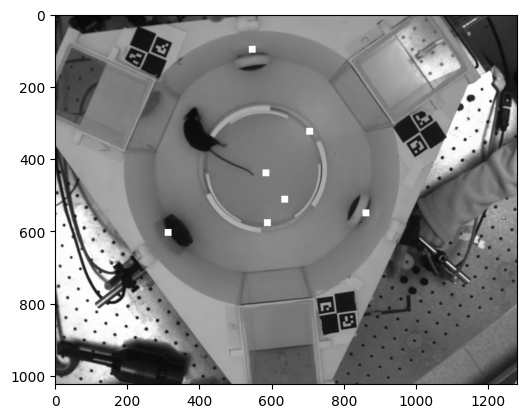

In [183]:
from matplotlib import pyplot as plt
plt.imshow(img)
plt.show()

In [281]:
import os
print(os.getcwd())

/Users/patrickdwyer/Documents/Scwartz_Lab/Triangulator/notebooks


In [295]:
downloads_path = "/Users/patrickdwyer/Downloads/"

In [762]:
from torch.utils.data import Dataset
import os
import cv2
import random
import torch

def get_trial_images(trial_dirs):
    tmp = []
    for cur_dir in trial_dirs:
        cur_imgs = sorted(list(map(lambda x: cur_dir + x, os.listdir(cur_dir))))
        tmp.append(cur_imgs)
    min_len = len(tmp[0])
    for lst in tmp:
        min_len = min(len(lst),min_len)
    p = np.random.permutation(min_len)
    imgs = []
    for lst in tmp:
        cur_imgs = lst[:min_len]
        cur_imgs = np.array(cur_imgs)
        cur_imgs = cur_imgs[p]
        cur_imgs = cur_imgs.tolist()
        imgs.append(cur_imgs)
        print(cur_imgs[0])
    return imgs

def get_base_imgs(cam_names, base_img_dir):
    base_images = []
    for cam_name in cam_names:
        base_img_path = base_img_dir+"camera_"+cam_name+"_base_img.png"
        base_img = cv2.imread(base_img_path)
        base_img = cv2.cvtColor(base_img, cv2.COLOR_BGR2GRAY)
        base_img = base_img.astype("float32",copy=False)
        base_img /= np.max(base_img)
        base_images.append(base_img)
    return base_images

class ImagesDataset(Dataset):
  # img_paths is a list of directories, each directory contains a directory for each camera
    def __init__(self, img_paths, cameras, transform=None, target_transform=None):
        self.transform = transform
        self.target_transform = target_transform
        self.num_trials = len(img_paths)
        self.num_cameras = len(img_paths[0])
        self.imgs = []
        self.cams = cameras
        assert self.num_trials == 1
        for i in range(self.num_trials):
            lst = get_trial_images(img_paths[i])
            self.imgs += lst # check this op later when we have multiple trials

    def __len__(self):
        return len(self.imgs[0])

    def __getitem__(self, idx):
        out = []
        tmp = []
        for i in range(self.num_cameras):
            cam_img_list = self.imgs[i]
            img_path = cam_img_list[idx]
            init_img = cv2.imread(img_path)
            init_img = cv2.cvtColor(init_img, cv2.COLOR_BGR2GRAY)
            img = init_img.astype("float32",copy=True)
            init_img = init_img.astype("float32",copy=False)
            init_img /= np.max(init_img)
            img /= np.max(img)
            base_img = self.cams[i].base_img
            subtracted = np.abs(img - base_img)
            subtracted = np.where(subtracted > self.cams[i].px_cutoff, 1.0, 0.0)
            out.append(subtracted)
            tmp.append(init_img)
        for img in tmp:
            out.append(img)
        out = np.asarray(out)

        return out

In [763]:
image_shape = np.array([1024,1280])

base_path = downloads_path

N_cams = 4

name1 = "17391290"
name2 = "17391304" # top cam
name3 = "19412282"
name4 = "21259803"
names = [name1,name2,name3,name4]

K1 = np.array([[365.99998268853614, 0.0, 653.5836307711236],[0.0, 362.54269203501826, 524.2898251351193],[ 0.0, 0.0, 1.0]])
K2 = np.array([[1681.4567542003983, 0.0, 639.5656045632381],[0.0, 1684.09437531831, 511.39077900281455],[0.0, 0.0, 1.0]])
K3 = np.array([[365.99998268853614, 0.0, 653.5836307711236],[0.0, 362.54269203501826, 524.2898251351193],[0.0, 0.0, 1.0]])
K4 = np.array([[365.99998268853614, 0.0, 653.5836307711236],[0.0, 362.54269203501826, 524.2898251351193],[0.0, 0.0, 1.0]])
Ks = [K1,K2,K3,K4]

D1 = np.array([0.06606845837702091, -0.06201870735392536, 0.05175078971151844, -0.013604518309950266])
D2 = np.array([-0.09329021100102836, -0.015373120930106288, 0.01682495507715212, -0.0272950838970061, 2.051106767874866, 0.09422046169167524, -0.004912591698594109, 1.438207444196221, 0.026447670217746067, 0.005462499898000899, -0.015115712037627299, -0.012697358649902119, -0.029058318376981435, -0.06767148991259063])
D3 = np.array([0.06606845837702091, -0.06201870735392536, 0.05175078971151844, -0.013604518309950266])
D4 = np.array([0.06606845837702091, -0.06201870735392536, 0.05175078971151844, -0.013604518309950266])
Ds = [D1,D2,D3,D4]

BigT1 = np.array([[ -0.9988512200551544, 0.043491384384982415, -0.02011814302084402, -0.763123986941524], [ -0.028159114981956473, -0.1930294179994544, 0.9807888192828389, -31.06215637460763], [ 0.038772470101379686, 0.9802286178596653, 0.1940323485689126, 1.594259421824204], [ 0.0, 0.0, 0.0, 1.0]])
BigT2 = np.array([[ 0.9999569195887527, 0.001794420968667116, -0.009107086249737644, 0.2888088672435886], [ -0.001752078231171209, 0.9999876292272218, 0.004655278121889946, -0.15001638716214752], [ 0.009115327116719876, -0.004639121243026419, 0.9999476933148291, 0.034206925537038246], [ 0.0, 0.0, 0.0, 1.0]])
BigT3 = np.array([[ 0.44291242408315173, -0.895954991190699, -0.033064155111858284, -0.12309494502546652], [ -0.10124781416453565, -0.08662625383473538, 0.991082626360418, -30.298525509057924], [ -0.8908296496635539, -0.4356151350757163, -0.1290813285230491, 7.976794111722069], [ 0.0, 0.0, 0.0, 1.0]])
BigT4 = np.array([[ 0.5093793508741311, 0.8569679205886, -0.07834960105259109, 3.998798335582383], [ 0.02952233249985642, 0.07359067539717384, 0.9968514655546011, -30.49690829849623], [ 0.860035527630584, -0.5100886154156347, 0.012185878570874109, 5.645966786117385], [ 0.0, 0.0, 0.0, 1.0]])
BigTs = [BigT1,BigT2,BigT3,BigT4]

px_cutoffs = [0.25, 0.25, 0.25, 0.25]

base_imgs = get_base_imgs(names, base_path+"base_images/")

cams = []

for i in range(4):
    fisheye = True
    if i == 1:
        fisheye = False
    name = names[i]
    K = Ks[i]
    D = Ds[i]
    BigT = BigTs[i]
    px_cutoff = px_cutoffs[i]
    base_img = base_imgs[i]
    cam = Camera(name, image_shape, K, D, BigT, fisheye, px_cutoff, base_img)
    cams.append(cam)


In [764]:
import multiprocessing
num_cpu_cores = multiprocessing.cpu_count()
from torch.utils.data import DataLoader

cam1 = "camera_17391290"
cam2 = "camera_17391304"
cam3 = "camera_19412282"
cam4 = "camera_21259803"
cam_dirs = [list(map(lambda x: base_path+x+"_images/",[cam1,cam2,cam3,cam4]))]
images_dataset = ImagesDataset(cam_dirs, cams)
data_loader = DataLoader(
    images_dataset,
    batch_size = 5,
    #num_workers = num_cpu_cores,
    shuffle = False,
    pin_memory = False
)

/Users/patrickdwyer/Downloads/camera_17391290_images/img00002178.png
/Users/patrickdwyer/Downloads/camera_17391304_images/img00002178.png
/Users/patrickdwyer/Downloads/camera_19412282_images/img00002178.png
/Users/patrickdwyer/Downloads/camera_21259803_images/img00002178.png


In [765]:
print(images_dataset.imgs[0][0])
print(images_dataset.imgs[1][0])

#plt.imshow(images_dataset[0][0], "gray");

/Users/patrickdwyer/Downloads/camera_17391290_images/img00002178.png
/Users/patrickdwyer/Downloads/camera_17391304_images/img00002178.png


In [766]:
batch = next(data_loader.__iter__())
pics = batch[0]

In [767]:
pics.shape

torch.Size([8, 1024, 1280])

In [768]:
for i in range(0,4):
    plt.subplot(2, 4, i+1)
    plt.imshow(pics[i], "gray")
    plt.subplot(2,4, 5+i)
    plt.imshow(pics[4+i], "gray")
plt.show()

In [769]:
def circle_eq(x, y):
    return np.sqrt((x-center_x)**2+(y-center_y)**2)

In [783]:
# make sure everything passed into here is good (x vs y)
def line_passes_through_circle(line_start, line_end, circle_eq, num_points=10):
    dire = line_end - line_start
    length = np.linalg.norm(dire)
    dire = dire / length
    interval_length = length / (num_points - 1)
    point = line_start
    if circle_eq(point[0],point[1]) <= inner_radius:
        return True
    for i in range(1, num_points):
        point = point + interval_length
        if circle_eq(point[0],point[1]) <= inner_radius:
            return True
    return False

In [771]:
r = 9
arena_height = 39
ppi = 5
num_x_points = num_y_points = (r * 2 * ppi) + 1
num_z_points = (arena_height * ppi) + 1
# following two vals were painstakingly tested/computed
center_x = -1.199405162390885
center_y = -1.6960642799627483
x, y, z = np.linspace(-r,r,num_x_points), np.linspace(-r,r,num_y_points), np.linspace(0,arena_height,num_z_points)

In [772]:
inner_radius = 3.0
outer_radius = 6.693
xxx, yyy, zzz = np.meshgrid(x,y,z)
assert(xxx.shape==yyy.shape)
assert(yyy.shape==zzz.shape)

In [773]:
circle = np.sqrt(((xxx-center_x)**2)+((yyy-center_y)**2))
donut = np.logical_and(circle >= inner_radius, circle <= outer_radius)

In [774]:
donut_points = np.rot90(np.vstack(list(map(np.ravel, [xxx[donut],yyy[donut],zzz[donut]]))))
donut_points

array([[ 0.4,  4.8, 39. ],
       [ 0.4,  4.8, 38.8],
       [ 0.4,  4.8, 38.6],
       ...,
       [-2.6, -8.2,  0.4],
       [-2.6, -8.2,  0.2],
       [-2.6, -8.2,  0. ]])

In [784]:
def in_bounds(image_shape, point):
    if point[0] >= 0 and point[0] < image_shape[1] and point[1] >= 0 and point[1] < image_shape[0]:
        return True
    return False
    

In [801]:
def bilinear_interp(image, image_point):
    image_x = image_point[0]
    image_y = image_point[1]
    if image_x.is_integer() and image_y.is_integer():
        if not in_bounds(image, image_point):
            return 0.0
        return image[image_y, image_x]
    x1 = int(image_x // 1)
    x2 = x1 + 1
    y1 = int(image_y // 1)
    y2 = y1 + 1
    val = 1 / ((x2-x1)*(y2-y1))
    bot_left = 0.0
    bot_right = 0.0
    top_left = 0.0
    top_right = 0.0
    if in_bounds(list(image.shape), [x1,y1]):
        bot_left = image[y1,x1]
    if in_bounds(list(image.shape), [x1,y2]):
        bot_right = image[y2,x1]
    if in_bounds(list(image.shape), [x2,y1]):
        top_left = image[y1,x2]
    if in_bounds(list(image.shape), [x2,y2]):
        top_right = image[y2,x2]
    # just copied from wikipedia
    # np.dot() does matmul if dim correct (dot product just a special case of matmul if you transpose the vector to the right)
    #val = val * np.dot(np.array([x2-image_x,image_x-x1]), np.dot(np.array([[bot_left,bot_right],
                                                                             #[top_left,top_right]]), np.array([y2-image_y,image_y-y1])))
    if bot_left == 1.0 and bot_right == 1.0 and top_left == 1.0 and top_right == 1.0:
        return 1.0
    else:
        return 0.0



In [802]:
def assess_images(images, cams, points):
    assert(len(images)==len(cams))
    heat_map = {}
    for n in range(len(points)):
        point = points[n]
        for i in range(len(cams)):
            if line_passes_through_circle(cams[i].cam_pos, point, circle_eq) or point[2] < 27:
                continue
            
            image_point = cams[i].project(point).reshape(2)
            heat = bilinear_interp(images[i], image_point[[1,0]])
            heat_map[point.tobytes()] = heat_map.get(point.tobytes(), 0.0) + heat
    return heat_map

In [803]:
def idx_converter(point, range_begin, range_end, num_points):
    interval_length = (range_end - range_begin) / (num_points - 1)
    idx = (point - range_begin) / interval_length
    return round(idx)

In [804]:
all_points = np.rot90(np.vstack(list(map(np.ravel, [xxx,yyy,zzz]))))
print(x[0])
print(x[-1])

-9.0
9.0


In [805]:
def generate_model_input(heat_map, all_points):
    heats = torch.zeros(len(z),len(y),len(x),dtype=torch.float)
    for point in all_points:
        x_idx = idx_converter(point[0], x[0], x[-1], num_x_points)
        y_idx = idx_converter(point[1], y[0], y[-1], num_y_points)
        z_idx = idx_converter(point[2], z[0], z[-1], num_z_points)

        heat_val = heat_map.get(point.tobytes(),0.0)
        heats[z_idx,y_idx,x_idx] = heat_val
    return heats

In [806]:
donut_points.shape
donut_points[0].dtype
assert(round(192.00000000000003) == 192)
assert(round(186.99999999999997) == 187)

In [807]:
print(donut_points.shape)
heat_map = assess_images(pics[0:4].detach().cpu().numpy(), cams, donut_points)


(552132, 3)


In [808]:
model_input = generate_model_input(heat_map, all_points)
model_input.shape

torch.Size([196, 91, 91])

<IPython.core.display.Javascript object>


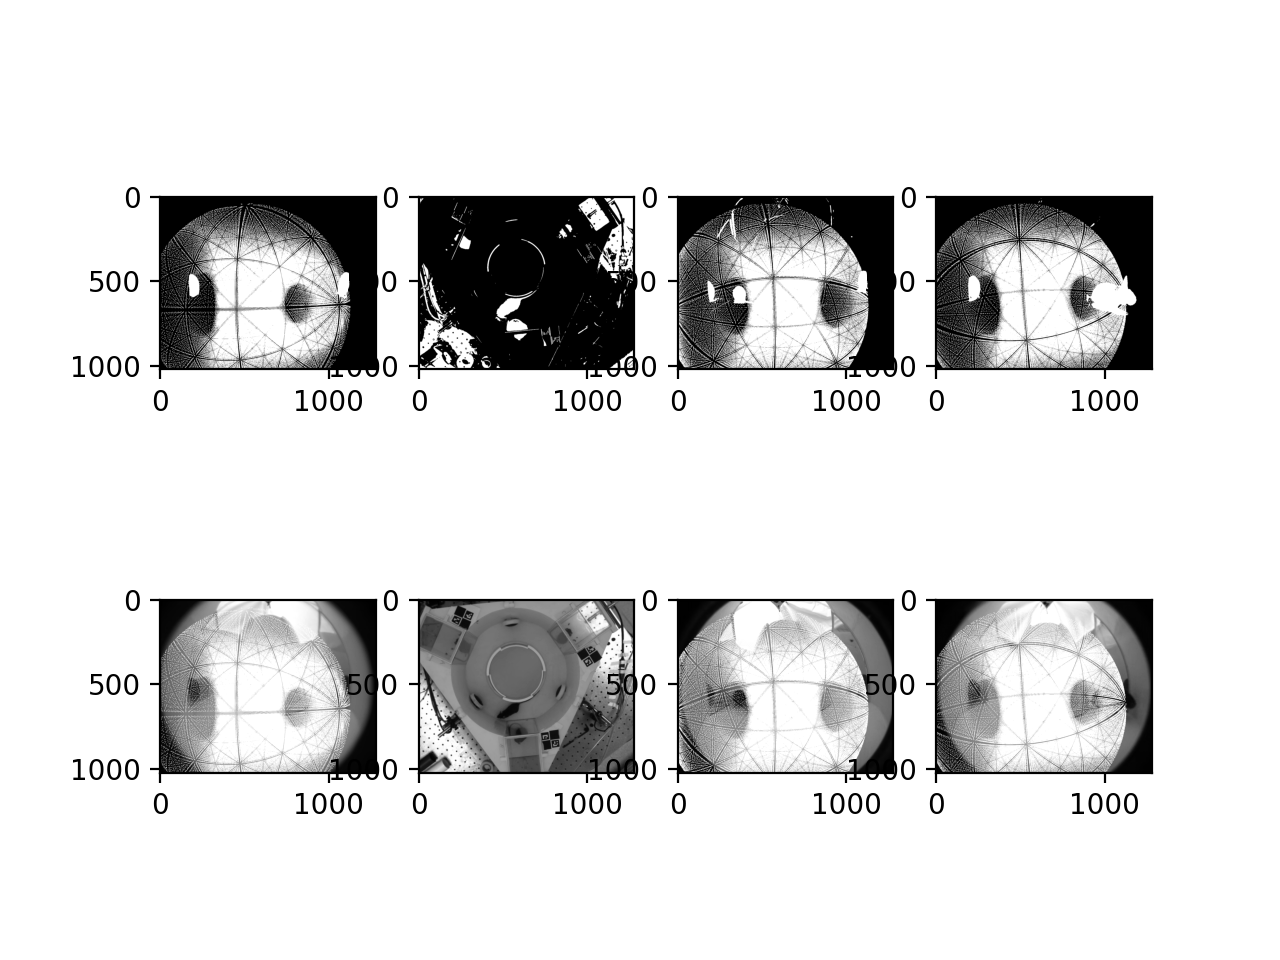

In [810]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
greensx = []
greensy = []
greensz = []
redsx = []
redsy = []
redsz = []
blacksx = []
blacksy = []
blacksz = []
yellowsx = []
yellowsy = []
yellowsz = []
for k in range(num_z_points):
    for j in range(num_y_points):
        for i in range(num_x_points):
            val = model_input[k,j,i].item()
            if val <= 1.0 and val > 0.0:
                greensx.append(i)
                greensy.append(j)
                greensz.append(k)
            if val > 1.0 and val <= 2.0:
                redsx.append(i)
                redsy.append(j)
                redsz.append(k)
            if val > 2.0 and val <= 3.0:
                blacksx.append(i)
                blacksy.append(j)
                blacksz.append(k)
            if val > 3.0:
                yellowsx.append(i)
                yellowsy.append(j)
                yellowsz.append(k)
#ax.scatter(greensx,greensy,greensz,color="g", marker= 'o')
ax.scatter(redsx,redsy,redsz,color="r", marker= 'o')
ax.scatter(blacksx,blacksy,blacksz,color="m", marker= 'o')
ax.scatter(yellowsx,yellowsy,yellowsz,color="b", marker= 'o')
ax.set_xlabel('x axis')
ax.set_ylabel('y axis')
ax.set_zlabel('z axis')
plt.show()

In [832]:
print(cams[0].image_shape)
projected = pics.detach().cpu().numpy().copy()

[1024 1280]


In [833]:
def draw_square(point, img):
    for i in range(-1,2):
        for j in range(-1,2):
            cur_point_y,cur_point_x = int(point[1])+j,int(point[0])+i
            if in_bounds(img.shape, [cur_point_x,cur_point_y]):
                img[cur_point_y,cur_point_x] = 1.
    return img

In [834]:

for point in donut_points:
    for i in range(len(cams)):
        cam = cams[i]
        if line_passes_through_circle(cam.cam_pos, point, circle_eq) or point[2] < 27:
            continue
        image_point = cam.project(point).reshape(2)
        image_y = max(min(round(image_point[0]), 1023), 0)
        image_x = max(min(round(image_point[1]), 1279), 0)
        val = heat_map.get(point.tobytes(), None)
        if val is not None:
            projected[i] = draw_square([image_x,image_y],projected[i])
            projected[i+4] = draw_square([image_x,image_y],projected[i+4])


In [835]:
for i in range(0,4):
    plt.subplot(2, 4, i+1)
    plt.imshow(projected[i], "gray")
    plt.subplot(2,4, 5+i)
    plt.imshow(projected[4+i], "gray")
plt.show()

In [760]:
pics[0,:,:].shape

(1024, 1280)